In [1]:
#import scaper
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import Thesis_models
import Thesis_models_nonTime

sr = 24000




In [2]:
# Use if on GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# Not in order of the MultiLabelBinarizer, disregard the order
DESED_classes = ['Alarm_bell_ringing', 'Blender', 'Cat', 'Dishes', 'Dog', 'Electric_shaver_toothbrush', 'Frying', 'Running_water', 'Speech', 'Vacuum_cleaner']

In [3]:
# Loading the soundscapes and creating the labels


scene_path = '/Volumes/Expansion/DESED/Dataset_Output_Folder/audio/train/synthetic21_train/soundscapes/'
#uni_name = 'soundscape_unimodal' 
scene_size = sr*10

# Create dict for labels

#labels_dict = {'non-vehicle':0, 'cars':1, 'motorcycles':2, 'tanks':3, 'trucks':4}
#labels_names = ['no_event','cars', 'motorcycles', 'tanks', 'trucks']

def audio_input_shaper(path, available_ids):
    audio_input = (np.zeros(1,10,4096,1))
    for i in available_ids:
        audio, _ = librosa.load(path + str(i)+'.wav', sr=sr, mono=True)
        x = np.pad(audio, (2861,2898))
        x = np.reshape(x, (6,10,4096,1))
        audio_input = np.concatenate((audio_input, x), axis=0)

    audio_input = audio_input[0,:]

    return audio_input

n_soundscapes = 100

#features = np.zeros((1,10,4096,1))
#labels = np.zeros((1, 10, 1))

features = []
labels = []

for scns in range(n_soundscapes):
    scene, _ = librosa.load(scene_path + str(scns) + '.wav', sr=sr, mono=True)
    
    x1 = np.pad(scene, (2861,2898))
    x = np.reshape(x1, (6,10,4096,1))
    features.append(x)
    #features = np.concatenate((features, x), axis=0)

    headers = ['onset', 'offset', 'label']
    txt = pd.read_csv(scene_path + str(scns) + '.txt', sep='\t',  names=headers, index_col=False)

    # split scene in chunks for labels
    chunk_size = 4096
    time_step = 64
    step_size = chunk_size//time_step
    
    # Iterating through the whole sound scene capturing labels
    for i in range(0, x1.size, step_size):
        labels_temp = []
        for b, row in txt.iterrows():
            onset = int(row['onset'])*sr
            offset = int(row['offset'])*sr
            if onset < (i+step_size) and offset > (i):
                labels_temp.append(row['label'])
            else:
                pass    
    
        for label in labels_temp:
            if label in DESED_classes:

                pass
            else:
                labels_temp = ['None']
        labels.append(labels_temp)
        

features_out = np.concatenate(features, axis=0)
print('Labels before MultiLabelBinarizer one row example: {}'.format(labels[0]))
print('Labels before MultiLabelBinarizer second row example: {}'.format(labels[1]))
one_hot = MultiLabelBinarizer()
labels = one_hot.fit_transform(labels) 
label_names = one_hot.classes_
print('Labels shape before reshape is {}'.format(labels.shape))
print('Labels one row example: {}'.format(labels[0]))
print('Labels one row example: {}'.format(labels[1]))
labels = np.reshape(labels, ((n_soundscapes*6),10, step_size, len(label_names)))

print(features_out.shape, labels.shape)
print(label_names)

Labels before MultiLabelBinarizer one row example: ['None']
Labels before MultiLabelBinarizer second row example: ['None']
Labels shape before reshape is (384000, 11)
Labels one row example: [0 0 0 0 0 0 0 1 0 0 0]
Labels one row example: [0 0 0 0 0 0 0 1 0 0 0]
(600, 10, 4096, 1) (600, 10, 64, 11)
['Alarm_bell_ringing' 'Blender' 'Cat' 'Dishes' 'Dog'
 'Electric_shaver_toothbrush' 'Frying' 'None' 'Running_water' 'Speech'
 'Vacuum_cleaner']


In [4]:
# Check one instance of labels
print('Labels one row example: {}'.format(labels[200,6,1,:]))

Labels one row example: [0 0 0 0 0 1 0 0 0 0 0]


In [5]:
# Remove None class (Optional)
idx = np.where(label_names == 'None')
labels = np.delete(labels, idx, axis=-1)
print(labels.shape)
print('Labels one row example: {}'.format(labels[0,0,0,:]))
label_names = np.delete(label_names, idx, 0)
print(label_names)

(600, 10, 64, 10)
Labels one row example: [0 0 0 0 0 0 0 0 0 0]
['Alarm_bell_ringing' 'Blender' 'Cat' 'Dishes' 'Dog'
 'Electric_shaver_toothbrush' 'Frying' 'Running_water' 'Speech'
 'Vacuum_cleaner']


In [6]:
tf.keras.backend.clear_session()

In [7]:
# Models 

'''Only build one model at a time, otherwise layer names will be confused'''


# This model is LSTM Raw audio with time distributed frontend
LSTM_RAe2e = Thesis_models.LSTM_backend_2(10, 4096, 128, 64, n_of_classes=len(label_names), frame_level_classification=False, output_dim=64, melspec=False, sr=sr)
LSTM_RAe2e.summary()
time_dist_backend = False
'''
# This model is CRNN with Raw audio frontend, time distributed front and backend 
CRNN_RAe2e = Thesis_models.CRNN(len(label_names), 128, [5, 2, 2], [64, 64], [32], 10, 4096, 128, 64, sr=sr, melspec=False)
CRNN_RAe2e.summary()
time_dist_backend = True

# This model is CRNN with mel spec input, time distributed front and backend 
CRNN_Mel = Thesis_models.CRNN(len(label_names), 128, [5, 2, 2], [64, 64], [32], 10, 4096, 128, 64, sr=sr, melspec=True)
CRNN_Mel.summary()
time_dist_backend = True

# This model is LSTM time distributed front and back, melspecs as input (not working)
LSTM_Mel = Thesis_models.LSTM_backend(10, 4096, 128, 64, n_of_classes=len(label_names), frame_level_classification=False, output_dim=64, melspec=True, sr=sr)
LSTM_Mel.summary()
time_dist_backend = True

# This model is LSTM with time distributed front and back, raw audio as input (original model)
LSTM_RAe2e = Thesis_models.LSTM_backend(10, 4096, 128, 64, n_of_classes=len(label_names), frame_level_classification=False, output_dim=64, melspec=False, sr=sr)
LSTM_RAe2e.summary()
time_dist_backend = True'''

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10, 4096, 1)]     0         
                                                                 
 conv (TimeDistributed)      (None, 10, 4096, 128)     8320      
                                                                 
 conv_activation (TimeDistri  (None, 10, 4096, 128)    0         
 buted)                                                          
                                                                 
 conv_smoothing (TimeDistrib  (None, 10, 4096, 128)    16512     
 uted)                                                           
                                                                 
 conv_smoothing_activation (  (None, 10, 4096, 128)    0         
 TimeDistributed)                                                
                                                              

'\n# This model is CRNN with Raw audio frontend, time distributed front and backend \nCRNN_RAe2e = Thesis_models.CRNN(len(label_names), 128, [5, 2, 2], [64, 64], [32], 10, 4096, 128, 64, sr=sr, melspec=False)\nCRNN_RAe2e.summary()\ntime_dist_backend = True\n\n# This model is CRNN with mel spec input, time distributed front and backend \nCRNN_Mel = Thesis_models.CRNN(len(label_names), 128, [5, 2, 2], [64, 64], [32], 10, 4096, 128, 64, sr=sr, melspec=True)\nCRNN_Mel.summary()\ntime_dist_backend = True\n\n# This model is LSTM time distributed front and back, melspecs as input (not working)\nLSTM_Mel = Thesis_models.LSTM_backend(10, 4096, 128, 64, n_of_classes=len(label_names), frame_level_classification=False, output_dim=64, melspec=True, sr=sr)\nLSTM_Mel.summary()\ntime_dist_backend = True\n\n# This model is LSTM with time distributed front and back, raw audio as input (original model)\nLSTM_RAe2e = Thesis_models.LSTM_backend(10, 4096, 128, 64, n_of_classes=len(label_names), frame_level_

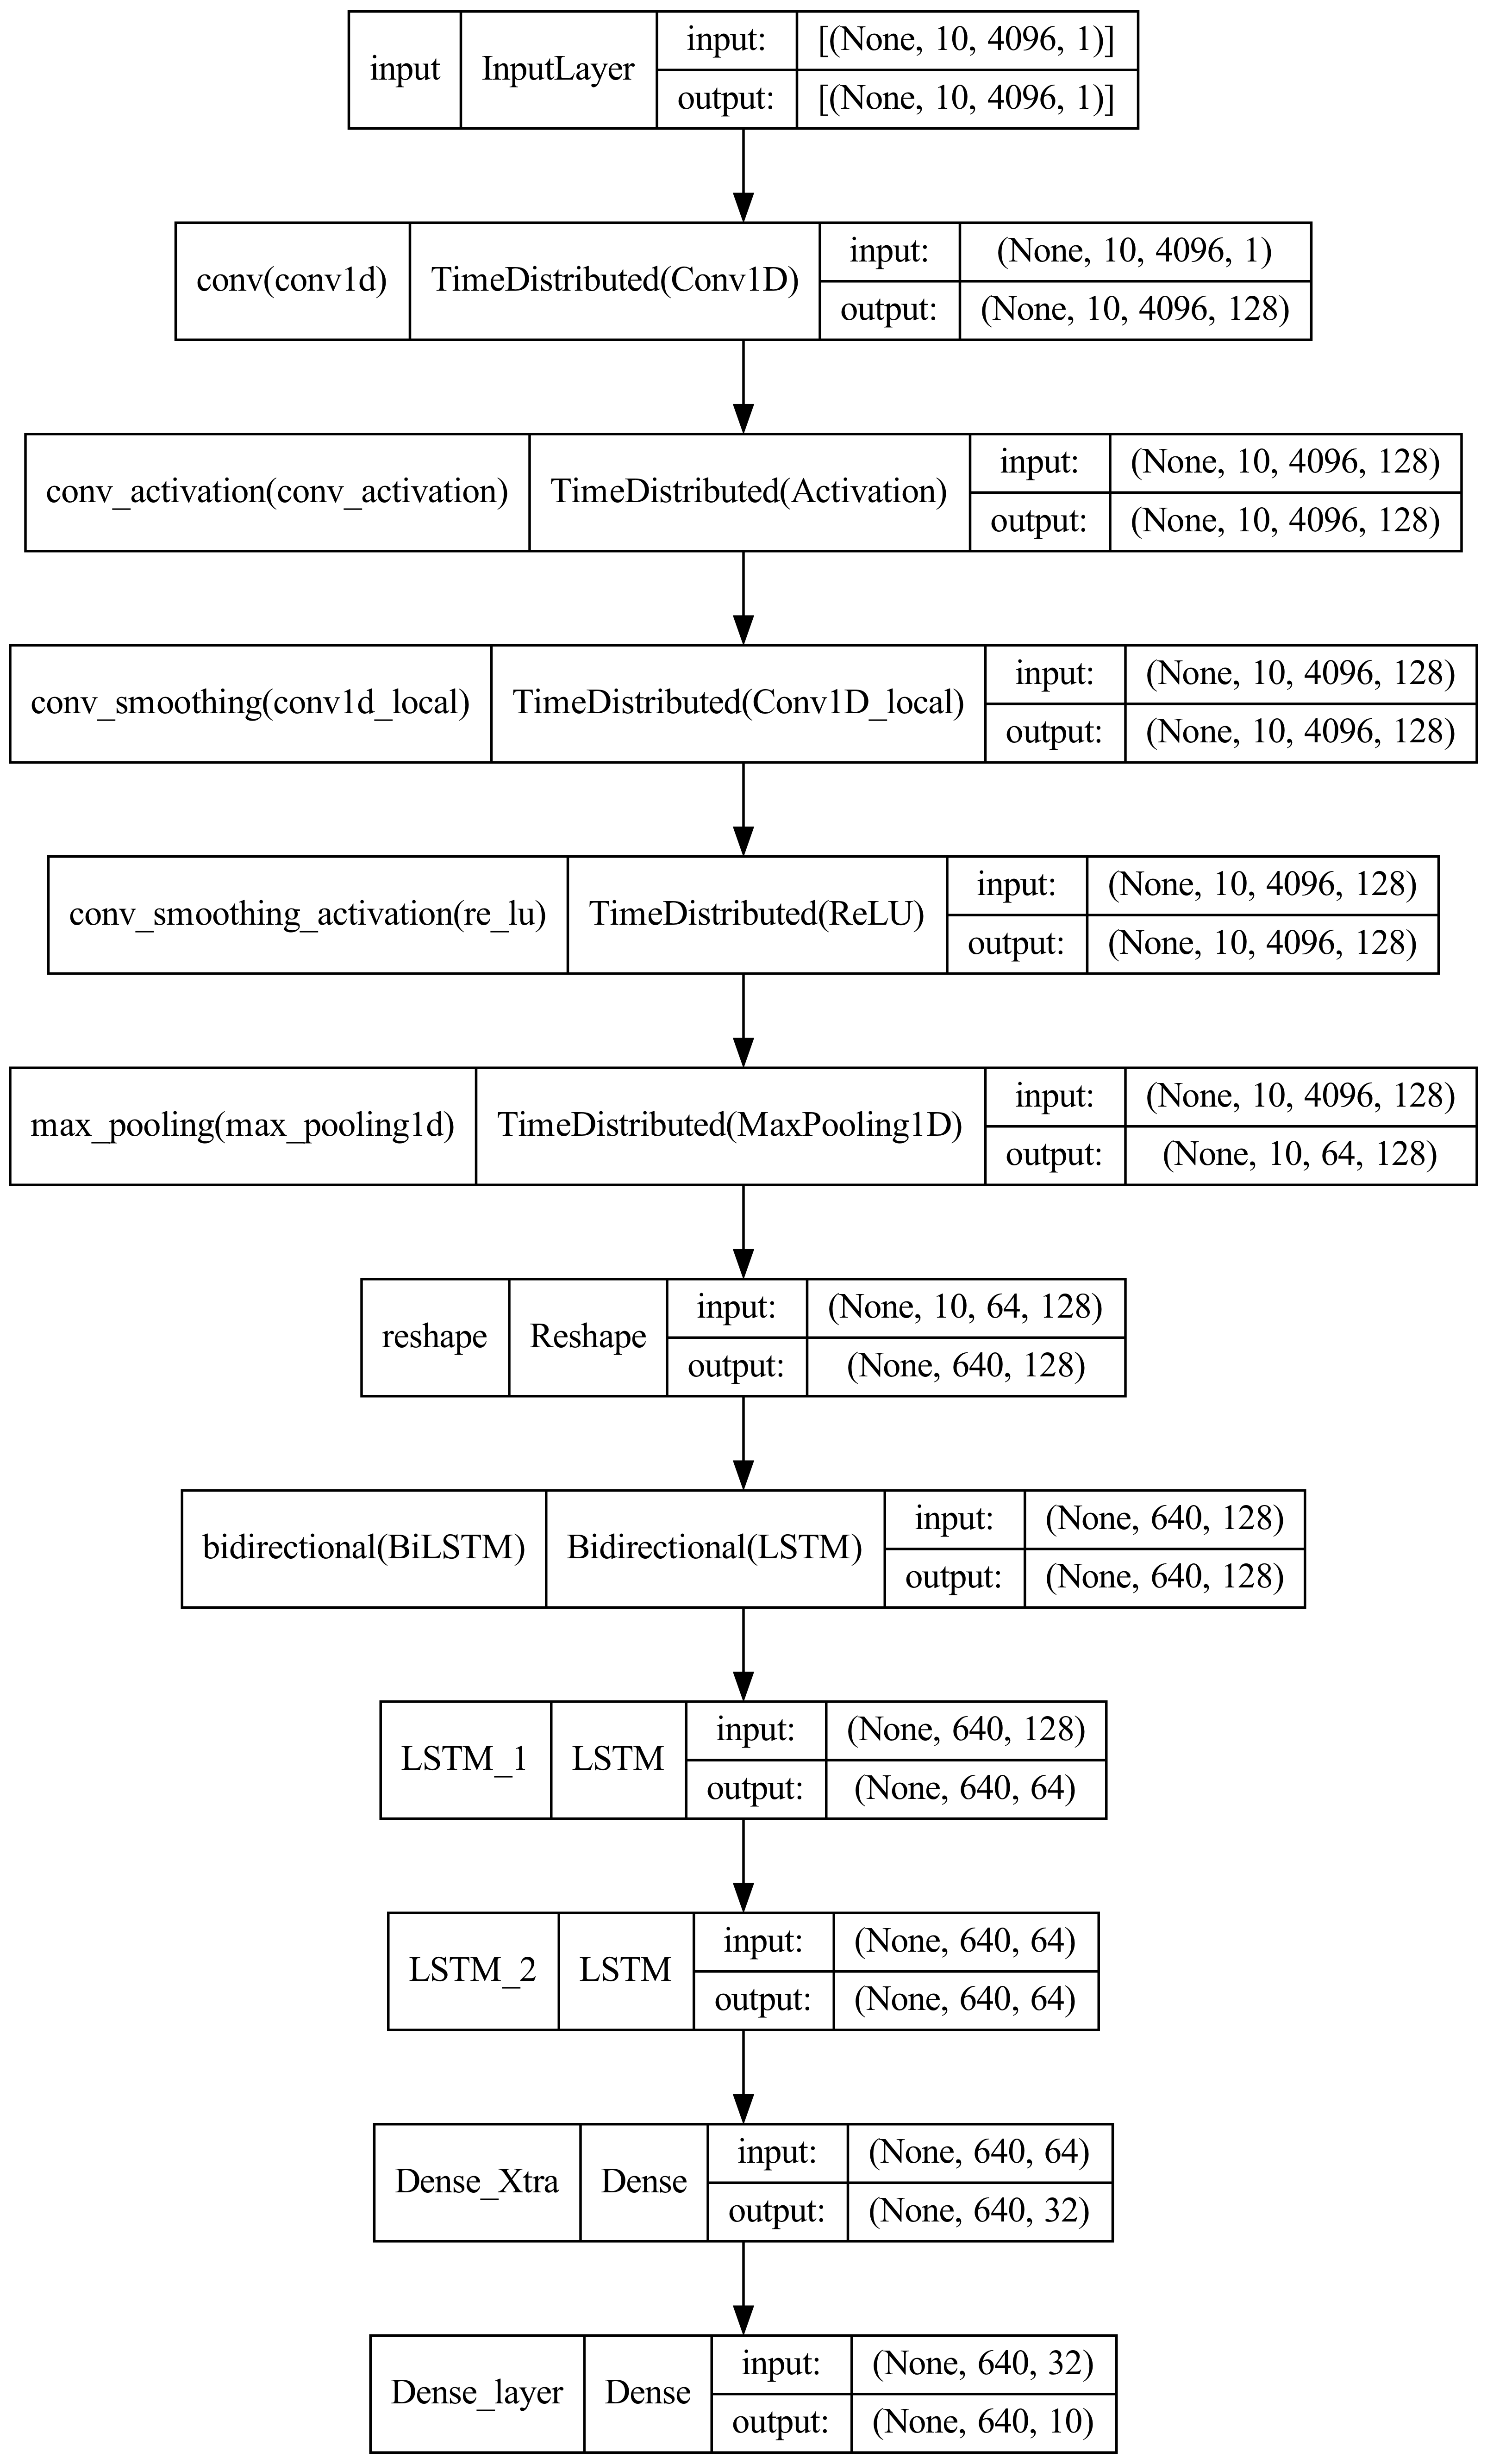

In [10]:
# Create png of model plot

from tensorflow.keras.utils import plot_model

plot_model(LSTM_RAe2e, 'LSTM_RAe2e.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=396)

In [8]:
# Splitting into training and testing data for prelim evaluation

from sklearn.model_selection import train_test_split 
feat_train, feat_test, lab_train, lab_test = train_test_split(features_out, labels, test_size=0.2, random_state=42)

print(feat_train.shape)

(480, 10, 4096, 1)


In [9]:
print(lab_train.shape)

(480, 10, 64, 10)


In [10]:
#  Run this cell only if using RNN layers which are not timedistributed (LSTM_backend_2)
if time_dist_backend == False:
    lab_train_ = np.reshape(lab_train, (lab_train.shape[0],(lab_train.shape[1]*lab_train.shape[2]),len(label_names)))
    print(lab_train_.shape)
else:
    pass

(480, 640, 10)


Epoch 1/4
384/384 [==============================] - 969s 3s/step - loss: 0.1373 - accuracy: 0.0617 - val_loss: 0.1575 - val_accuracy: 0.0815
Epoch 2/4
384/384 [==============================] - 1112s 3s/step - loss: 0.1369 - accuracy: 0.0718 - val_loss: 0.1592 - val_accuracy: 0.0815
Epoch 3/4
384/384 [==============================] - 1139s 3s/step - loss: 0.1375 - accuracy: 0.0467 - val_loss: 0.1605 - val_accuracy: 0.0815
Epoch 4/4
384/384 [==============================] - 1013s 3s/step - loss: 0.1374 - accuracy: 0.0736 - val_loss: 0.1584 - val_accuracy: 0.0815


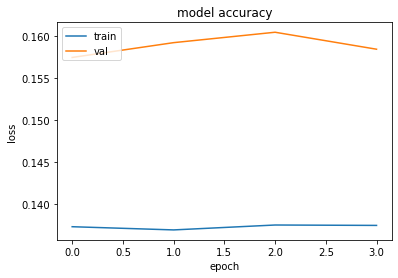

In [13]:
# For LSTM_backend_2 set batch to 1. For all others batch = 10
batch = 1
callback_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

history = LSTM_RAe2e.fit(
    feat_train,
    lab_train_,
    validation_split=0.2,
    #class_weight= {0: 1.0, 1: 1.0, 2: 0.5, 3: 0.5, 4: 1.0},
    batch_size=batch,
    shuffle=True,
    epochs=4,
    callbacks = [callback_stop]
    
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [14]:
if time_dist_backend == False:
    lab_test_ = np.reshape(lab_test, (lab_test.shape[0],(lab_test.shape[1]*lab_test.shape[2]),len(label_names)))
    print(lab_test_.shape)
    LSTM_RAe2e.evaluate(feat_test, lab_test_)
else:
    LSTM_RAe2e.evaluate(feat_test, lab_test)

(120, 640, 10)
4/4 [==============================] - 53s 11s/step - loss: 0.1677 - accuracy: 0.1100


* CRNN_Rafe 1 epoch 100 soundscapes (approx 12 minutes): loss: 0.2611 - accuracy: 0.3840
* CRNN_RAe2e 1 ep 100sc (fixed LR, rnns:[64,64]): [0.2245444357395172, 0.4411458373069763]
* LSTM_Rafe 1 epoch 100 soundscapes (approx 9 min): loss: 0.2174 - accuracy: 0.5179
* LSTM RAe2e 1 ep 100s (fixed LR no sched) : loss: 0.2451 - accuracy: 0.4411
* LSTM_mel 10 epochs 100 soundscapes (approx 7s pr epoch): loss: 0.2120 - accuracy: 0.4411 (Didn't seem to learn, loss decreased but accuracy remained the same)
* CRNN_Mel 10 epochs 100 soundscapes (approx 2:30 min pr epoch): loss: 0.2177 - accuracy: 0.4411 (Didn't seem to learn. Guess the log mels are blank...)
* CRNN_Mel 2 eps 100s (mels flipped 90 degrees): loss: 0.2165 - accuracy: 0.4411

NO TIME DISTRIBUTION TESTS:
* LSTM_RAe2e 10 epochs (10 soundscapes)(1 minute each) shuffle=True: [0.1243598461151123, 0.4678385555744171]
* LSTM_RAe2e 10 epochs (10 soundscapes) shuffle=False: [0.15079300105571747, 0.4694010317325592] (Did not "learn", loss and accuracy almost identical all epochs)

TIME DIST ONLY ON FRONTEND:
* LSTM_RAe2e 1 epoch 100 soundscapes (15 min): loss: 0.2130 - accuracy: 0.4411
* LSTM RAe2e 1 ep 1000 soundscapes (2 hours+):  loss: 0.1895 - accuracy: 0.5547

Time dist frontend; No None Class
* LSTMRAe2e 1 epoch 100 soundscapes no None: loss: 0.1698 - accuracy: 0.1100
* LSTMRAe2e 5 eps 100 soundscapes no None: loss: 0.1677 - accuracy: 0.1100

In [10]:
path = '/Users/arvidfalch/Documents/Thesis/Idfrontend2/RAe2e/Models/'
model_description = '1epoch_LSTM_RAe2e_notime_rnns_1000sc'
tf.keras.models.save_model(LSTM_RAe2e, path + model_description)

2023-01-19 07:55:31.541654: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/arvidfalch/Documents/Thesis/Idfrontend2/RAe2e/Models/1epoch_LSTM_RAe2e_notime_rnns_1000sc/assets
